In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from collections import defaultdict

import json

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

import itertools

import random

from skimage import measure
import dill
import csv


#### SIMPLE IMAGE EXAMPLE FROM TRAINING-SET

In [2]:
def read_image(path):
    return plt.imread(path)

(480, 640)


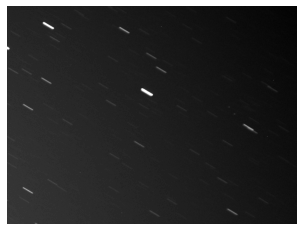

In [3]:
example_image=read_image('geoSatellites/train/1/1.png')
print(example_image.shape)
plt.imshow(example_image, cmap='gray')
plt.axis('off')
plt.show()

##### STORE THE ANNOTATION FILE RECORDINGS IN A DICTIONARY

In [4]:
def read_annotation_file(path):
    with open(path) as annotation_file:
        annotation_list = json.load(annotation_file)
    # Transform list of annotations into dictionary
    annotation_dict = {}
    for annotation in annotation_list:
        sequence_id = annotation['sequence_id']
        if sequence_id not in annotation_dict:
            annotation_dict[sequence_id] = {}
        annotation_dict[sequence_id][annotation['frame']] = annotation['object_coords']
    return annotation_dict

train_annotation=read_annotation_file('geoSatellites/train_anno.json')

## FUNCTIONS THAT HELP US BUILD THE DATASET

In [5]:
random.seed(0)

#function to choose a negative sample randomly from an image, with restriction of not being the positive ones or near to them
def random_different_coordinates(coords, size_x, size_y, pad,cond):
    """ Returns a random set of coordinates that is different from the provided coordinates, 
    within the specified bounds.
    The pad parameter avoids coordinates near the bounds."""
    good = False
    while not good:
        good = True
        c1 = random.randint(0, size_x - 1)#(pad + 1))
        c2 = random.randint(0, size_y -1)#( pad + 1))
        
        #We choose negative samples in a manner that neither positive pixels, nor pixels in the around area of them are chosen
        #That's why we feed with the boolean cond=true if we don't want to choose the neighborhood pixels
        if cond:
            for c in coords:
                coordset_0 = range(int(c[0])-1,int(c[0])+2)
                coordset_1 = range(int(c[1])-1,int(c[1])+2)
                if c1 in coordset_0 and c2 in coordset_1:
                    good = False
                    break
        else:
            for c in coords:
                if c1==c[0] and c2==c[1]:
                    good = False
                    break
    return (c1,c2)

#This function returns the training features we will use (a square array of pixels in area of distance<=radius ) 

def extract_neighborhood(x, y, arr, radius):
    """ Returns a 1-d array of the values within a radius of the x,y coordinates given """
    
    #vec2 = np.ones((1,radius+1))
    if x>=radius and x<480-radius and y>=radius and y<640-radius:
        return arr[(x - radius) : (x + radius + 1), (y - radius) : (y + radius + 1)].ravel()
    if x>=480-radius and y>=radius and y<640-radius:
        #print("1")
        vecx = np.zeros((x-479+radius,2*radius+1))
        myarr = arr[(x - radius) : 480, (y - radius) : (y + radius + 1)]
        myarr = np.append(myarr,vecx,axis=0)
    if x<radius and y>=radius and y<640-radius:
        #print("2")
        vecx = np.zeros((radius-x,2*radius+1))
        #vecy = np.ones((1,radius-y))
        myarr = arr[0 : (x + radius + 1), (y - radius) : (y + radius + 1)]
        #myarr = arr[0 : (xx2+1), (yy1- 1) : (yy2 + 1)]
        myarr = np.append(vecx,myarr,axis=0)
    if y>=640-radius and x>=radius and x<480-radius:
        #print("3")
        vecy = np.zeros((y-639+radius,2*radius+1))
        myarr = arr[(x - radius) : (x + radius + 1), (y - radius) : 640]
        #myarr = arr[(xx1- 1) : (xx2+1), (yy1- 1) : yy2]
        myarr = np.append(myarr,vecy.T,axis=1)
    if y<radius and x<480-radius and x>=radius:
        #print("4")
        vecy = np.zeros((radius-y,2*radius+1))
        #vecy = np.ones((1,radius-y))
        myarr = arr[ (x - radius) : (x + radius + 1), 0 : (y + radius + 1)]
        #myarr = arr[0 : (xx2+1), (yy1- 1) : (yy2 + 1)]
        #myarr = np.append(vecx,myarr,axis=0)
        myarr = np.append(vecy.T,myarr,axis=1)
    if y<radius and x<radius:
        #print("5")
        vecx = np.zeros((radius-x,radius+1+y))
        myarr = arr[ 0 : (x + radius + 1), 0 : (y + radius + 1)]
        myarr = np.append(vecx,myarr,axis=0)
        vecy = np.zeros((radius-y,2*radius+1))
        myarr = np.append(vecy.T,myarr,axis=1)
    if y>=640-radius and x>=480-radius:
        #print("6")
        vecx = np.zeros((x-479+radius,radius+640-y))
        myarr = arr[ (x - radius) : 480, (y-radius) : 640]
        myarr = np.append(myarr,vecx,axis=0)
        vecy = np.zeros((y-639+radius,2*radius+1))
        myarr = np.append(myarr,vecy.T,axis=1)
    if y>=640-radius and x<radius:
        #print("7")
        vecx = np.zeros((radius-x,radius+640-y))
        myarr = arr[ 0 : (x + radius + 1), (y-radius) : 640]
        myarr = np.append(vecx,myarr,axis=0)
        vecy = np.zeros((y-639+radius,2*radius+1))
        myarr = np.append(myarr,vecy.T,axis=1)
        #
    if x>=480-radius and y<radius:
        #print("8")
        vecx = np.zeros((x-479+radius,radius+1+y))
        myarr = arr[ (x-radius) : 480, 0 : (y+radius+1)]
        myarr = np.append(myarr,vecx,axis=0)
        vecy = np.zeros((radius-y,2*radius+1))
        myarr = np.append(vecy.T,myarr,axis=1)
        #
    #print(myarr.shape)
    return myarr.ravel()    
    #return arr[(x - radius) : (x + radius + 1), (y - radius) : (y + radius + 1)].ravel()

#check if we can include the pixel, or it's in the edges and we can't have its neighborhood

def check_coordinate_validity(x, y, size_x, size_y, pad):
    """ Check if a coordinate is not too close to the image edge """
    return x >= pad and y >= pad and x + pad < size_x and y + pad < size_y

#Append to training set every positive sample in the given images and a given number of negative samples

def generate_labeled_data(image_path, annotation, nb_false, radius,cond):
    """ For one frame and one annotation array, returns a list of labels 
    (1 for true object and 0 for false) and the corresponding features as an array.
    nb_false controls the number of false samples
    radius defines the size of the sliding window (e.g. radius of 1 gives a 3x3 window)"""
    features,labels = [],[]
    im_array = read_image(image_path)
    # True samples
    for obj in annotation:
        obj = [int(x + .5) for x in obj] #Project the floating coordinate values onto integer pixel coordinates.
        # For some reason the order of coordinates is inverted in the annotation files
        #if check_coordinate_validity(obj[1],obj[0],im_array.shape[0],im_array.shape[1],radius):
        features.append(extract_neighborhood(obj[1],obj[0],im_array,radius))
        labels.append(1)
            #features.append(extract_neighborhood(obj[1],obj[0],im_array,radius))
            #labels.append(1)
    # False samples
    for i in range(nb_false):
        c = random_different_coordinates(annotation,im_array.shape[1],im_array.shape[0],radius,cond)
        features.append(extract_neighborhood(c[1],c[0],im_array,radius))
        labels.append(0)
    return np.array(labels),np.stack(features,axis=1)

In [6]:
def generate_labeled_set(annotation_array, path, sequence_id_list, radius, nb_false,cond):
    # Generate labeled data for a list of sequences in a given path
    labels,features = [],[]
    for seq_id in sequence_id_list:
        for frame_id in range(1,6):
            d = generate_labeled_data(f"{path}{seq_id}/{frame_id}.png",
                                    annotation_array[seq_id][frame_id],
                                    nb_false,
                                    radius,cond)
            labels.append(d[0])
            features.append(d[1])
    return np.concatenate(labels,axis=0), np.transpose(np.concatenate(features,axis=1))

### DEFINE RADIUS AND CREATE TRAINING SET

In [7]:
radius=3
train_labels, train_features = generate_labeled_set(train_annotation,'geoSatellites/train/', range(1,601), radius, 20,True)
print(train_labels.shape)
print(train_labels)
print(train_features.shape)

(65335,)
[1 1 1 ... 0 0 0]
(65335, 49)


In [8]:
import pandas as pd


## TRAIN A STACKING META-CLASSIFIER FROM PROBABILITIES OF 3 DIFFERENT CLASSIFIERS

In [9]:
from sklearn.svm import SVC
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
#linear = LinearSVC(C=100)
#clf = CalibratedClassifierCV(linear)
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=43,solver= 'adam', max_iter= 1000, learning_rate= 'constant', hidden_layer_sizes=(100, 50), alpha= 0.001, activation= 'relu')
RF = RandomForestClassifier(n_estimators=500, max_depth=30, random_state=0)
svc = SVC(C=100,gamma=1,probability=True)

lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf, RF,svc],
                          use_probas=True,
                          meta_classifier=lr)

import time
start_time = time.time()
sclf.fit(train_features,train_labels)
print(time.time()-start_time)


592.7342653274536


### BUILD TEST SET

In [10]:
test_labels, test_features = generate_labeled_set(train_annotation,'geoSatellites/train/', range(601,1201), radius, 500,True)


## FUNCTION TO GIVE RESULTS OF PREDICTIONS BASED ON A PROBABILITY THRESHOLD

In [11]:
def probab_classify(threshold,svc_labels):
    svc_labels_temp = np.where(svc_labels>threshold)
    svc_labels_f = []
    last = 0 
    #print(svc_labels_temp[0])
    for i,val in enumerate(svc_labels_temp[0]):
        for j in range(last,val):
            svc_labels_f.append(0)
        if svc_labels_temp[1][i]==1:
            svc_labels_f.append(1)
        else:
            svc_labels_f.append(0)
        last = val+1
    for j in range(last,svc_labels.shape[0]):
        svc_labels_f.append(0)
    return svc_labels_f

### FUNCTION TO PRINT CLASSIFICATION RESULTS, CONF MATRIX AND APPEND THEM ON A CSV 

In [12]:
def write_results(threshold,radius,svc_labels_f,test_labels):
    with open('geo_resultsStacking.csv', 'a', newline='') as csvfile:
        resultwriter = csv.writer(csvfile, delimiter=' ')
        resultwriter.writerow( ['Stack', 'RADIUS = '+str(radius),'NEGATIVE SAMPLING 25 ONE AND DONE 1-501+501-800 PROBABS thresh = '+str(threshold)])
    report = classification_report(test_labels,svc_labels_f,output_dict=True)
    print(report)
    df = pd.DataFrame(report).transpose()
    df.to_csv('geo_resultsStacking.csv',mode='a')
    cf = confusion_matrix(test_labels,svc_labels_f)
    print(cf)
    df = pd.DataFrame(cf)
    df.to_csv('geo_resultsStacking.csv',mode='a')
    print("Kappa =",cohen_kappa_score(test_labels,svc_labels_f))
    with open('geo_resultsStacking.csv', 'a', newline='') as csvfile:
        resultwriter = csv.writer(csvfile, delimiter=' ')
        resultwriter.writerow( ["Kappa = ",cohen_kappa_score(test_labels,svc_labels_f)])

### PREDICTION WITH PROBABILITIES, TRANSFORMATION ON A THRESHOLD=0.5 AND RESULTS

In [13]:
# If we provide a stricter threshold, then we will get higher precision but lower recall. 
sclf_labels = sclf.predict_proba(test_features)
sclf_labels_f = probab_classify(0.7,sclf_labels)
write_results(0.7,radius,sclf_labels_f,test_labels)

{'0': {'precision': 0.9994270344788855, 'recall': 0.99658, 'f1-score': 0.9980014867843432, 'support': 1500000}, '1': {'precision': 0.4573151380514123, 'recall': 0.8345559845559846, 'f1-score': 0.5908562837422265, 'support': 5180}, 'accuracy': 0.9960224026362295, 'macro avg': {'precision': 0.7283710862651489, 'recall': 0.9155679922779922, 'f1-score': 0.7944288852632848, 'support': 1505180}, 'weighted avg': {'precision': 0.997561384109166, 'recall': 0.9960224026362295, 'f1-score': 0.9966003173881525, 'support': 1505180}}
[[1494870    5130]
 [    857    4323]]
Kappa = 0.589028945951103


In [14]:
sclf_labels_f = probab_classify(0.5,sclf_labels)
write_results(0.5,radius,sclf_labels_f,test_labels)

import joblib
joblib.dump(sclf3,'Stacking1clfAfterAct.pkl')

{'0': {'precision': 0.999493314020811, 'recall': 0.99551, 'f1-score': 0.9974976803777661, 'support': 1500000}, '1': {'precision': 0.3963972037999641, 'recall': 0.8538610038610038, 'f1-score': 0.5414371404088627, 'support': 5180}, 'accuracy': 0.9950225222232557, 'macro avg': {'precision': 0.6979452589103876, 'recall': 0.9246855019305019, 'f1-score': 0.7694674103933143, 'support': 1505180}, 'weighted avg': {'precision': 0.9974177895978555, 'recall': 0.9950225222232557, 'f1-score': 0.9959281713509127, 'support': 1505180}}
[[1493265    6735]
 [    757    4423]]
Kappa = 0.5392714122545694


In [15]:
train_labels2, train_features2 = generate_labeled_set(train_annotation,'geoSatellites/train/', range(601,1201), radius, 20,True)


In [16]:
#linear2 = LinearSVC(C=100)
#clf2 = CalibratedClassifierCV(linear2)
clf2 = MLPClassifier(random_state=43,solver= 'adam', max_iter= 1000, learning_rate= 'constant', hidden_layer_sizes=(100, 50), alpha= 0.0005, activation= 'relu')
RF2 = RandomForestClassifier(n_estimators=500, max_depth=30, random_state=0)
svc2 = SVC(C=100,gamma=1,probability=True)

lr2 = LogisticRegression()
sclf2 = StackingClassifier(classifiers=[clf2, RF2,svc2],
                          use_probas=True,
                          meta_classifier=lr2)

import time
start_time = time.time()
sclf2.fit(train_features2,train_labels2)
print(time.time()-start_time)

636.4111964702606


In [17]:
test_labels2, test_features2 = generate_labeled_set(train_annotation,'geoSatellites/train/', range(1,601), radius, 500,True)
sclf2_labels = sclf2.predict_proba(test_features2)
sclf2_labels_f = probab_classify(0.5,sclf2_labels)
write_results(0.5,radius,sclf2_labels_f,test_labels2)

import joblib
joblib.dump(sclf3,'Stacking2clfafterAct.pkl')

{'0': {'precision': 0.9994413460148903, 'recall': 0.995886, 'f1-score': 0.9976605054857574, 'support': 1500000}, '1': {'precision': 0.4217036828788305, 'recall': 0.8434864104967198, 'f1-score': 0.5622891415719106, 'support': 5335}, 'accuracy': 0.9953458864638104, 'macro avg': {'precision': 0.7105725144468604, 'recall': 0.9196862052483599, 'f1-score': 0.779974823528834, 'support': 1505335}, 'weighted avg': {'precision': 0.9973938081360588, 'recall': 0.9953458864638104, 'f1-score': 0.9961175225440997, 'support': 1505335}}
[[1493829    6171]
 [    835    4500]]
Kappa = 0.5602108903800469


# WE APPLY AN ACTIVE LEARNING APPROACH
## We add the samples that were predicted wrong in the training set and restart the process from the beginning

In [19]:
#find indexes where label prediction is 1 but the real one is 0(false positives)
def uncertainty_s(svc_labels_probs,train_features,train_labels,test_features,test_labels):
    svc_labels_probs = np.array(svc_labels_probs)
    #print(svc_labels_probs)
    #newarr = svc_labels_probs[0][:]
    #print(newarr)
    index_probs = np.where(abs(svc_labels_probs-0.5)<0.3)
    index_probs = np.unique(index_probs[0])
    #print(act_index[0],act_index[0].shape[0])
    #print(index_probs)
    print(np.array(index_probs).shape)
    indlist=[]
    for i in index_probs:
        if test_labels[i]==0:
            indlist.append(i)
    train_features_x = test_features[indlist]
    train_labels_x = test_labels[indlist]
    train_features = np.concatenate((train_features,train_features_x))
    train_labels = np.concatenate((train_labels,train_labels_x))
    return train_labels,train_features

import random
def modify_trainset(svc_labels_f,train_features,train_labels,test_features,test_labels):
    svc_labels_f = np.array(svc_labels_f)
    act_index = np.where(svc_labels_f>0.325)
    #print(act_index[0],act_index[0].shape[0])
    indlist=[]
    for num,i in enumerate(act_index[0]):
        if act_index[1][num] == 1 and test_labels[i]==0:
            indlist.append(i)
    train_features_x = test_features[indlist]
    train_labels_x = test_labels[indlist]
    neglist = []
    for i in range(0,train_features.shape[0]):
        r = random.randint(0,1)
        if train_labels[i] == 1 or r == 1:
            neglist.append(i)
    train_features = train_features[neglist]
    train_labels = train_labels[neglist]
    train_features = np.concatenate((train_features,train_features_x))
    train_labels = np.concatenate((train_labels,train_labels_x))
    return train_labels,train_features

#find indexes where label prediction is 0 but the real one is 1(false negatives)
def modify_trainset_rev(svc_labels_f,train_features,train_labels,test_features,test_labels):
    svc_labels_f = np.array(svc_labels_f)
    act_index = np.where(test_labels==1.0)
    #print(act_index[0],act_index[0].shape[0])
    indlist=[]
    for i in act_index[0]:
        #if svc_labels_f[i]==0:
        indlist.append(i)
    train_features_x = test_features[indlist]
    train_labels_x = test_labels[indlist]
    train_features = np.concatenate((train_features,train_features_x))
    train_labels = np.concatenate((train_labels,train_labels_x))
    return train_labels,train_features
train_labelsE,train_featuresE = modify_trainset(sclf_labels,train_features,train_labels,test_features,test_labels)
#train_labelsE,train_featuresE = modify_trainset_rev(sclf_labels_f,train_featuresE,train_labelsE,test_features,test_labels)
train_labels2E,train_features2E = modify_trainset(sclf2_labels,train_features2,train_labels2,test_features2,test_labels2)
#train_labels2,train_features2 = modify_trainset_rev(sclf2_labels_f,train_features2,train_labels2,test_features2,test_labels2)

## FIT AGAIN THE STACKING CLASSIFIER

In [20]:
'''linear = LinearSVC(C=100)
clf = CalibratedClassifierCV(linear)
RF = RandomForestClassifier(n_estimators=500, max_depth=30, random_state=0)
svc = SVC(C=100,gamma=1,probability=True)

lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf, RF,svc],
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=lr)
print(train_features.shape)
start_time = time.time()
sclf.fit(train_features,train_labels)
print(time.time()-start_time)'''



'linear = LinearSVC(C=100)\nclf = CalibratedClassifierCV(linear)\nRF = RandomForestClassifier(n_estimators=500, max_depth=30, random_state=0)\nsvc = SVC(C=100,gamma=1,probability=True)\n\nlr = LogisticRegression()\nsclf = StackingClassifier(classifiers=[clf, RF,svc],\n                          use_probas=True,\n                          average_probas=False,\n                          meta_classifier=lr)\nprint(train_features.shape)\nstart_time = time.time()\nsclf.fit(train_features,train_labels)\nprint(time.time()-start_time)'

### TEST ON ANOTHER PART OF THE IMAGES AND CHECK RESULTS

In [21]:
test_labels3, test_features3 = generate_labeled_set(train_annotation,'geoSatellites/train/', range(1201,1281), radius, 500,True)
#sclf_labels = sclf.predict_proba(test_features)

In [22]:
#print(sclf_labels)
#sclf_labels_f = probab_classify(0.5,sclf_labels)
#print(sclf_labels_f)
#write_results(0.5,radius,sclf_labels_f,test_labels)

In [23]:
'''linear2 = LinearSVC(C=100)
clf2 = CalibratedClassifierCV(linear2)
RF2 = RandomForestClassifier(n_estimators=500, max_depth=30, random_state=0)
svc2 = SVC(C=100,gamma=1,probability=True)

lr2 = LogisticRegression()
sclf2 = StackingClassifier(classifiers=[clf2, RF2,svc2],
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=lr2)
start_time = time.time()
sclf2.fit(train_features2,train_labels2)
print(time.time()-start_time)'''


'linear2 = LinearSVC(C=100)\nclf2 = CalibratedClassifierCV(linear2)\nRF2 = RandomForestClassifier(n_estimators=500, max_depth=30, random_state=0)\nsvc2 = SVC(C=100,gamma=1,probability=True)\n\nlr2 = LogisticRegression()\nsclf2 = StackingClassifier(classifiers=[clf2, RF2,svc2],\n                          use_probas=True,\n                          average_probas=False,\n                          meta_classifier=lr2)\nstart_time = time.time()\nsclf2.fit(train_features2,train_labels2)\nprint(time.time()-start_time)'

In [24]:
#sclf_labels2 = sclf2.predict_proba(test_features)

In [25]:
#print(sclf_labels)
#sclf_labels_f2 = probab_classify(0.5,sclf_labels2)
#print(sclf_labels_f)
#write_results(0.5,radius,sclf_labels_f2,test_labels)

In [26]:
#linear3 = LinearSVC(C=100)
#clf3 = CalibratedClassifierCV(linear3)
clf3 = MLPClassifier(random_state=43,solver= 'adam', max_iter= 1000, learning_rate= 'constant', hidden_layer_sizes=(100, 50), alpha= 0.001, activation= 'relu')
RF3 = RandomForestClassifier(n_estimators=500, max_depth=30, random_state=0)
svc3 = SVC(C=100,gamma=1,probability=True)

lr3 = LogisticRegression()
sclf3 = StackingClassifier(classifiers=[clf3, RF3,svc3],
                          use_probas=True,
                          meta_classifier=lr3)
#train_features3 = np.concatenate((train_features,train_features2))
#train_labels3 = np.concatenate((train_labels,train_labels2))



In [27]:
print(train_featuresE.shape)
print(train_labelsE.shape)
print(train_features2E.shape)
print(train_labels2E.shape)
#train_labelsnew, train_featuresnew = generate_labeled_set(train_annotation,'geoSatellites/train/', range(1,1201), radius, 5,True)
train_features3 = np.concatenate((train_featuresE,train_features2E))
train_labels3 = np.concatenate((train_labelsE,train_labels2E))
#train_features3 = np.concatenate((train_featuresn,train_featuresnew))
#train_labels3 = np.concatenate((train_labelsn,train_labelsnew))

(43820, 49)
(43820,)
(43118, 49)
(43118,)


In [28]:
start_time = time.time()
sclf3.fit(train_features3,train_labels3)
print(time.time()-start_time)


2767.7388191223145


In [29]:
sclf_labels3 = sclf3.predict_proba(test_features3)
#print(sclf_labels)
sclf_labels_f3 = probab_classify(0.5,sclf_labels3)
#print(sclf_labels_f)
write_results(0.5,radius,sclf_labels_f3,test_labels3)

{'0': {'precision': 0.9992405316278605, 'recall': 0.99994, 'f1-score': 0.9995901434497926, 'support': 200000}, '1': {'precision': 0.9781818181818182, 'recall': 0.7797101449275362, 'f1-score': 0.8677419354838709, 'support': 690}, 'accuracy': 0.9991828192735064, 'macro avg': {'precision': 0.9887111749048394, 'recall': 0.8898250724637682, 'f1-score': 0.9336660394668317, 'support': 200690}, 'weighted avg': {'precision': 0.9991681288560345, 'recall': 0.9991828192735064, 'f1-score': 0.9991368310600547, 'support': 200690}}
[[199988     12]
 [   152    538]]
Kappa = 0.8673373194150988


In [30]:
sclf_labels_f3 = probab_classify(0.9,sclf_labels3)
#print(sclf_labels_f)
write_results(0.9,radius,sclf_labels_f3,test_labels3)

{'0': {'precision': 0.9989460960600975, 'recall': 0.999985, 'f1-score': 0.9994652780554113, 'support': 200000}, '1': {'precision': 0.9937759336099585, 'recall': 0.6942028985507246, 'f1-score': 0.8174061433447098, 'support': 690}, 'accuracy': 0.998933678808112, 'macro avg': {'precision': 0.996361014835028, 'recall': 0.8470939492753623, 'f1-score': 0.9084357107000606, 'support': 200690}, 'weighted avg': {'precision': 0.9989283203259275, 'recall': 0.998933678808112, 'f1-score': 0.9988393335492058, 'support': 200690}}
[[199997      3]
 [   211    479]]
Kappa = 0.816888311388863


In [31]:
import joblib
joblib.dump(sclf3,'StackingActUncWH.pkl')

['StackingActUncWH.pkl']

In [34]:
sclf_labels_f3 = probab_classify(0.97,sclf_labels3)
#print(sclf_labels_f)
write_results(0.97,radius,sclf_labels_f3,test_labels3)

{'0': {'precision': 0.9987864683732683, 'recall': 0.999995, 'f1-score': 0.9993903688268597, 'support': 200000}, '1': {'precision': 0.9977678571428571, 'recall': 0.6478260869565218, 'f1-score': 0.7855887521968365, 'support': 690}, 'accuracy': 0.9987841945288753, 'macro avg': {'precision': 0.9982771627580627, 'recall': 0.8239105434782609, 'f1-score': 0.8924895605118481, 'support': 200690}, 'weighted avg': {'precision': 0.9987829662468595, 'recall': 0.9987841945288753, 'f1-score': 0.9986552892739439, 'support': 200690}}
[[199999      1]
 [   243    447]]
Kappa = 0.7850067643694446


In [ ]:
sclf_labels_f3 = probab_classify(0.99,sclf_labels3)
#print(sclf_labels_f)
write_results(0.99,radius,sclf_labels_f3,test_labels3)